**RESEARCH QUESTIONS**

1. What subjects are most commonly depicted in artworks during the Italian Renaissance?

2. How does the iconography evolve over time?

3. In which geographical locations are certain objects/subjects more likely to be depicted?

---

### This notebook goes through a basic exploratory data analysis of the **Iconology Dataset** and **Zeri Photo Archive RDF Dataset** using Python.

I will perform different kinds of exploratory data analysis to gain an exhaustive understanding of the data represented in the two original datasets.

The various phases of the EDA will be:
1. Acquire and parse
2. Filter and mine
3. Represent
4. Refine
5. Interact

# 0. Why EDA?

**Data**, in their raw form, gain meaning through relational connections, transforming into **information**. Information answers questions starting with interrogative words like *who, what, when, where,* and *how many*. However, information truly becomes valuable when it evolves into **knowledge**. Knowledge represents a purposeful collection of information, intended for utility. As knowledge accumulates, it enables reflection, potentially leading to **wisdom**.

To achieve this progression, understanding serves as a continuum that begins with data, transitions through information and knowledge, and culminates in wisdom. This concept is encapsulated in the ***"DIKW Pyramid"*** (Ackoff, 1989), where data forms the foundational layer, leading to wisdom, the ultimate tier.

Data represent abstractions of concepts and real-world entities (such as people, paintings, or places) with their associated attributes or features, forming classes of objects. These data are then collated and stored in datasets, often represented in tabular format, where rows denote entities and columns represent their attributes.

Given the variability in such abstractions, **Exploratory Data Analysis (EDA)** becomes crucial in unraveling these structures. EDA aids in uncovering insights about the data, deciphering their representations and implications.

This is an iterative process since datasets consistently unveil features that might have been initially overlooked.

Let's embark on this journey!

# 1. Acquire and Parse

The initial dataset to be explored is the one created as a PhD project in Digital Humanities at the University of Bologna by *Sofia Baroncini*: **[Iconology Dataset](https://iconology-dataset.streamlit.app/)**.

This dataset is accessible in RDF format and is published at [https://w3id.org/icon/data/](https://w3id.org/icon/data/).


In [1]:
# Install the packages needed in the Notebook
#!pip install rdflib
#!pip install sparqlwrapper
#!pip install pandas
#!pip install prettyprinter
#!pip install matplotlib
#!pip install seaborn

In [2]:
# Import necessary libraries

# RDFlib
from rdflib import Graph, URIRef
from rdflib.plugins.sparql import prepareQuery

# SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON

# pandas
import pandas as pd

# prettyprinter
from prettyprinter import pprint

# matplotlib
import matplotlib.pyplot as plt

# seaborn
import seaborn as sns

# datatime
from datetime import datetime

# json
import json

Firstly, we parsed the RDF data into a graph to enable SPARQL queries for exploring the content.

In [3]:
# Initialize an RDF graph
iconology_graph = Graph()

# Define the endpoint URL
endpoint_url = 'https://w3id.org/icon/data/'

# Load the RDF data from the endpoint into the graph, specifying the format
try:
    iconology_graph.parse(endpoint_url, format='turtle')
    print("RDF data successfully loaded from the endpoint.")
except Exception as e:
    print("Failed to load RDF data from the endpoint:", e)

RDF data successfully loaded from the endpoint.


Understanding how data are structured in the datasets involves studying the ontology attached to them. The ***ICON ontology***, developed by *Bruno Sartini* and *Sofia Baroncini*, was created to formally represent interpretations about the content and meaning of artworks. It is based on Erwin Panofsky's theoretical approach, which subdivides each act of interpretation into three levels of understanding.

The ontology plays a crucial role in defining the structure, relationships, and entities within the dataset. In RDF datasets, ontologies establish the vocabulary and relationships used to describe the data. They provide the meaning of terms, properties, and classes, essential for correctly interpreting and querying the data.

To grasp the structure of the RDF, it's vital to consult the dataset documentation available [here](https://br0ast.github.io/ICON/ICONOntologyDocumentation/index-en.html). This step helps us identify the necessary prefixes for each query.

For a deeper exploration, we can inspect the list of classes available within our RDF dataset. The following code snippet demonstrates how we can retrieve this information using a SPARQL query.

In [4]:
# Define the SPARQL query
query = """
    SELECT DISTINCT ?class_uri
    WHERE {
        ?anything a ?class_uri .
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
lists_classes = iconology_graph.query(query_obj)

# Uncomment the two following lines to see the list of classes
#for row in lists_classes:
    #print(row['class_uri'])

We embark on our data exploration by seeking quantitative measures related to the dataset. Our initial step involves determining **the total number of artworks represented within the dataset.**
We've commenced our first query to collect essential statistics.

In [5]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/>
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?obj
    WHERE {
        ?obj crm:P65_shows_visual_item ?art.
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
artworks = len(set(results))

print(f"Number of distinct artworks: {artworks}")

Number of distinct artworks: 642


Let's count **how many, of the 642 artworks described, do have an artist specified.**

In [6]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?obj ?artistLabel
    WHERE {
    ?obj crm:P65_shows_visual_item ?artwork ;
         ^crm:P108_has_produced / crm:P14_carried_out_by ?artist.
    ?artist rdfs:label ?artistLabel. 

    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
artists_artworks = len(set(results))

print(f"Number of artworks with artist specified: {artists_artworks}")

Number of artworks with artist specified: 267


As our focus lies on the iconography depicted in the artworks, it's essential that these artworks have descriptions. Therefore, let's determine **the total count of artworks that have been described within the dataset.**

In [7]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?obj
    WHERE {
        ?obj crm:P65_shows_visual_item ?art. 
        ?rec icon:aboutWorkOfArt ?art. 
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
descripted_artworks = len(set(results))

print(f"Number of distinct described artworks: {descripted_artworks}")

Number of distinct described artworks: 428


As we can read in the Iconology documentation:
> Not all the artworks have a description. This is because the described artwork can have a relationship with a cultural object not described. In come cases, only a specific part of the artwork (e.g. a scene of a fresco, a relief on a church wall) is described. In other cases, there are other types of relations between the described artwork and another one (e.g. is companion piece of, is a copy of).

We are now interest into the different kind of artworks that are represented. So let's explore **how many artworks out of the described ones do have a type specified**

In [8]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

    SELECT DISTINCT ?obj ?typeLabel
    WHERE {                
        # Example commented out code that can be used to filter specific relationships:
        # VALUES ?rel {icon:hasCharacter icon:hasEvent icon:hasNamedObject icon:hasPlace icon:hasPersonification icon:hasSymbol}

        ?obj crm:P65_shows_visual_item ?artwork ;
             crm:P2_has_type ?type.
        ?type rdfs:label ?typeLabel.
        ?rec icon:aboutWorkOfArt ?artwork. 
    } 
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

# Calculate the number of distinct artworks
typed_artworks = len(set(results))

# Display the number of artworks with specified types
print(f"Number of artworks with type specified: {typed_artworks}")


Number of artworks with type specified: 342


Now that we a general overview of the dataset we can start plotting some visualization that could help us to better understand more quantitative information about the dataset. We can plot with seaborn library the different types specified and how they are distributed.

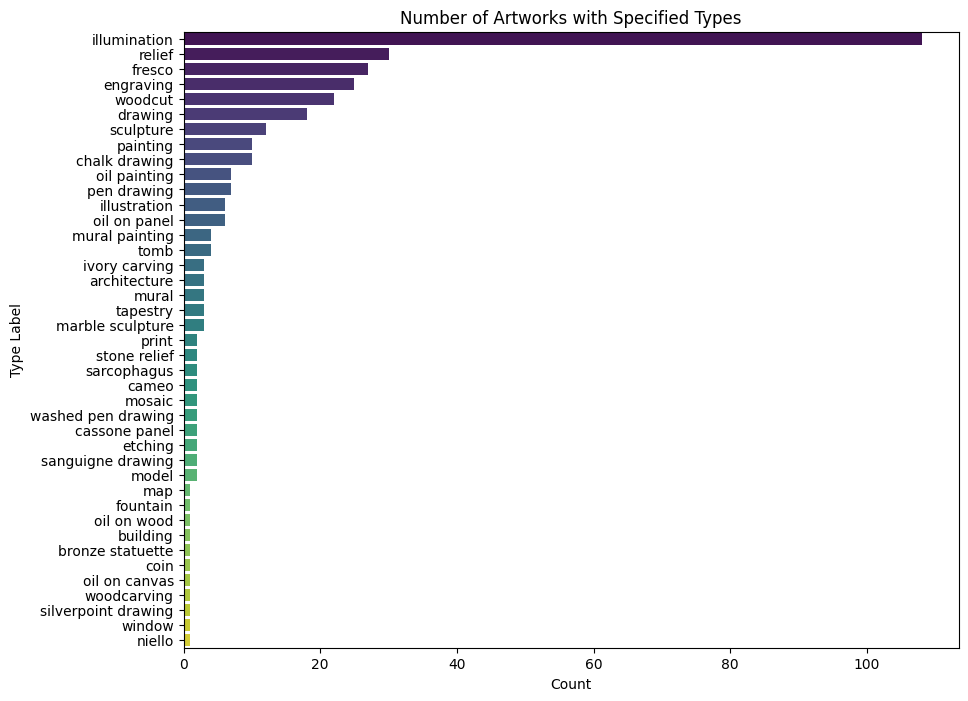

In [9]:
# Create a dictionary to store the counts of each type
type_counts = {}
for row in results:
    type_label = row['typeLabel']
    if type_label not in type_counts:
        type_counts[type_label] = 0
    type_counts[type_label] += 1

# Sort the type counts from the highest to the lowest
sorted_type_counts = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the labels and counts for plotting
type_labels, type_values = zip(*sorted_type_counts)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=list(type_values), y=list(type_labels), hue=list(type_labels), palette='viridis', order=list(type_labels), dodge=False, legend=False)

# Customize the plot
plt.xlabel('Count')
plt.ylabel('Type Label')
plt.title('Number of Artworks with Specified Types')
plt.show()

# 2. Filter and mine

We can continue our exploration by understanding the date feature of the artworks, when available. In our research we are interested in the time span of the Italian Renaissance, so 15th and 16th centuries. Let's query **how many artworks of the Italian Renaissance perios are represented in the dataset and of what type they are.**

Let's retrive the artworks that have a starting date between 1400 and 1600.

In [15]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    SELECT DISTINCT ?artwork ?title ?startDate ?endDate ?typeLabel
    WHERE {
        ?obj crm:P65_shows_visual_item ?artwork ;
            crm:P102_has_title ?title ;
            ^crm:P108_has_produced / crm:P4_has_time_span ?time .
            
        OPTIONAL {
            ?obj crm:P2_has_type ?type .
            ?type rdfs:label ?typeLabel .
        }
        ?rec icon:aboutWorkOfArt ?artwork .
        ?time crm:P82a_begin_of_the_begin ?startDate ;
            crm:P82b_end_of_the_end ?endDate .
            
        FILTER (xsd:dateTime(?startDate) >= "1400-01-01T00:00:00"^^xsd:dateTime &&
                xsd:dateTime(?startDate) <= "1600-12-31T23:59:59"^^xsd:dateTime)
    }
    ORDER BY ?startDate
"""

# Execute the query and retrieve the results
results = iconology_graph.query(query)

try:

    # Check if results exist
    if results:
        # Retrieve the count of distinct artworks within the specified time span
        count_artworks = sum(1 for artwork in results)

        if count_artworks > 0:
            print(f"Number of artworks within the Italian Renaissance period: {count_artworks}")
        else:
            print("No artworks found within the Italian Renaissance period")

        # Convert SPARQL results to a pandas DataFrame
        data = []
        for row in results:
            data.append({
                'Artwork': row['artwork'],
                'Title': row['title'],
                'Type': row['typeLabel'],
                'Start Date': row['startDate'],
                'End Date': row['endDate']
            })

        # Display the filtered results in a table
        if data:
            df = pd.DataFrame(data)
            print(df.head(10))  # Show the first 10 rows of the DataFrame
        else:
            print("No artworks found within the Italian Renaissance period")
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df  # Uncomment for a better reading of the table

Number of artworks within the Italian Renaissance period: 128
                                  Artwork  \
0      https://w3id.org/icon/data/ART1117   
1      https://w3id.org/icon/data/ART1118   
2      https://w3id.org/icon/data/ART1331   
3  https://w3id.org/icon/data/ART1004test   
4      https://w3id.org/icon/data/ART1007   
5  https://w3id.org/icon/data/ART1008test   
6      https://w3id.org/icon/data/ART1015   
7      https://w3id.org/icon/data/ART1292   
8      https://w3id.org/icon/data/ART1315   
9      https://w3id.org/icon/data/ART1431   

                                               Title          Type  \
0  https://w3id.org/icon/data/title/apollo-minerv...  illumination   
1  https://w3id.org/icon/data/title/orpheus-charm...  illumination   
2  https://w3id.org/icon/data/title/nature-and-grace        relief   
3  https://w3id.org/icon/data/title/the-rape-of-p...  illumination   
4     https://w3id.org/icon/data/title/celestial-map           map   
5  https://w3id.org/ic

,Artwork,Title,Type,Start Date,End Date
0,https://w3id.org/icon/data/ART1117,https://w3id.org/icon/data/title/apollo-minerv...,illumination,1400-01-01T00:00:00,1400-12-31T23:59:59
1,https://w3id.org/icon/data/ART1118,https://w3id.org/icon/data/title/orpheus-charm...,illumination,1400-01-01T00:00:00,1400-12-31T23:59:59
2,https://w3id.org/icon/data/ART1331,https://w3id.org/icon/data/title/nature-and-grace,relief,1400-01-01T00:00:00,1400-12-31T23:59:59
3,https://w3id.org/icon/data/ART1004test,https://w3id.org/icon/data/title/the-rape-of-p...,illumination,1401-01-01T00:00:00,1500-12-31T23:59:59
4,https://w3id.org/icon/data/ART1007,https://w3id.org/icon/data/title/celestial-map,map,1401-01-01T00:00:00,1500-12-31T23:59:59
...,...,...,...,...,...
123,https://w3id.org/icon/data/ART1380,https://w3id.org/icon/data/title/tityus,oil on canvas,1565-01-01T00:00:00,1565-12-31T23:59:59
124,https://w3id.org/icon/data/ART1426,https://w3id.org/icon/data/title/mater-miseric...,painting,1573-01-01T00:00:00,1573-12-31T23:59:59
125,https://w3id.org/icon/data/ART1322,https://w3id.org/icon/data/title/platonic-love...,engraving,1574-01-01T00:00:00,1574-12-31T23:59:59
126,https://w3id.org/icon/data/ART1389,https://w3id.org/icon/data/title/ganymede,engraving,1574-01-01T00:00:00,1574-12-31T23:59:59


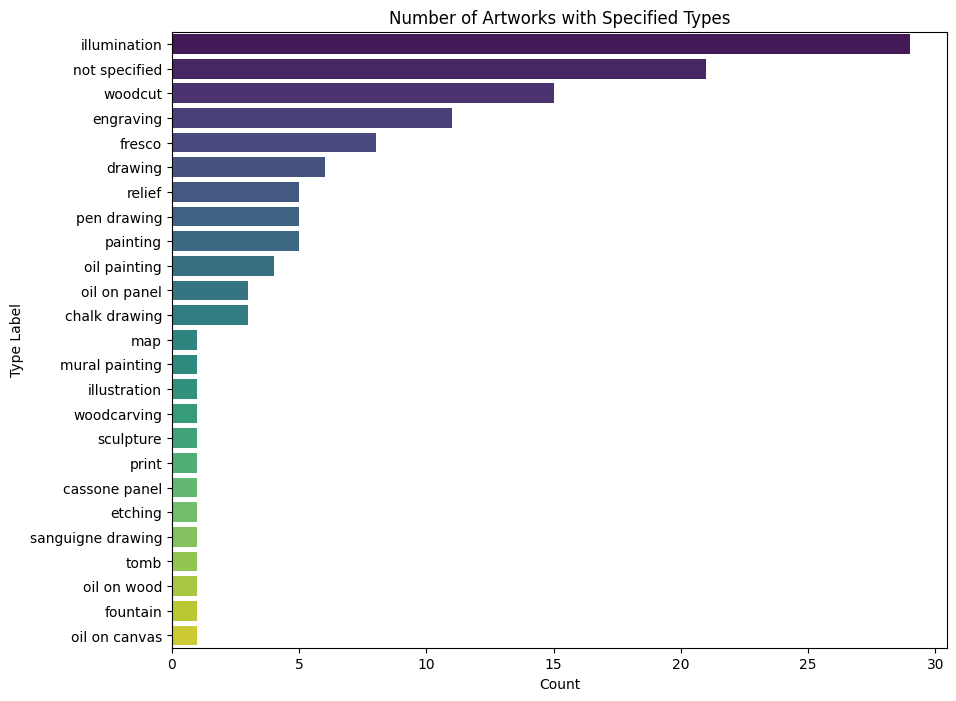

In [16]:
# Check if results exist
if results:
    # Create a dictionary to store the counts of each type
    type_counts = {}
    none_count = 0  # Counter for instances where typeLabel is None
    for row in results:
        type_label = row['typeLabel']
        if type_label is None:
            none_count += 1
        elif type_label not in type_counts:
            type_counts[type_label] = 1
        else:
            type_counts[type_label] += 1

    # Include the count of instances where typeLabel is None
    if none_count > 0:
        type_counts['not specified'] = none_count

    # Sort the type counts from the highest to the lowest
    sorted_type_counts = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the labels and counts for plotting
    type_labels, type_values = zip(*sorted_type_counts)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.barplot(x=list(type_values), y=list(type_labels), hue=list(type_labels), palette='viridis', order=list(type_labels), dodge=False, legend=False)

    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Type Label')
    plt.title('Number of Artworks with Specified Types')
    plt.show()
else:
    print("No results returned from the SPARQL query")


Since the dataset also accompanies artworks with evaluations of cultural phenomena by art historians, we thought it would be interesting to search within those labels to identify instances where the term 'Renaissance' is mentioned and ascertain the artworks to which it refers.

In [17]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX icon: <https://w3id.org/icon/ontology/>
    
    SELECT ?artwork ?culturalPhenomenon ?label ?intrinsicMeaning
    WHERE {
      ?artwork a icon:Artwork ;
               icon:iconologicallyRepresents ?culturalPhenomenon .
      ?culturalPhenomenon a icon:CulturalPhenomenon ;
                          rdfs:label ?label ;
                          icon:isCulturalPhenomenonOf ?intrinsicMeaning .
                          
      FILTER (REGEX(?label, "Renaissance", "i")) # "i" is case insensitive regex
    }
"""

# Prepare the SPARQL query
query_obj = prepareQuery(query)

# Execute the query and retrieve the results
results = iconology_graph.query(query_obj)

data = []
for row in results:
    data.append({
        'Artwork': row['artwork'],
        'Cultural Phenomenon': row['culturalPhenomenon'],
        'Sentence': row['label'],
        'Artwork\'s intrinsic meaning': row['intrinsicMeaning']
    })

# Display the results in a table
if data:
    df = pd.DataFrame(data)
    print(f"Total intrinsic meanings where the word \"Renaissance\" is cited: {len(df)}")
else:
    print("No intrinsic meanings where the word \"Renaissance\" is cited")

df.head()

Total intrinsic meanings where the word "Renaissance" is cited: 1129


,Artwork,Cultural Phenomenon,Sentence,Artwork's intrinsic meaning
0,https://w3id.org/icon/data/ART1432,https://w3id.org/icon/data/CF1044,Completing the existing structure with a gothi...,https://w3id.org/icon/data/ART1432-INTRINSIC1
1,https://w3id.org/icon/data/ART1433,https://w3id.org/icon/data/CF1052,Cover the gothic shapes with more contemporary...,https://w3id.org/icon/data/ART1433-INTRINSIC2
2,https://w3id.org/icon/data/ART1068,https://w3id.org/icon/data/CF1053,Crisis of the harmony conciliating the antique...,https://w3id.org/icon/data/ART1068-INTRINSIC1
3,https://w3id.org/icon/data/ART1200,https://w3id.org/icon/data/CF1069,"During Renaissance, Anteros is explicitly iden...",https://w3id.org/icon/data/ART1200-INTRINSIC1
4,https://w3id.org/icon/data/ART1151,https://w3id.org/icon/data/CF1094,Example of anticipation of Renaissance in the ...,https://w3id.org/icon/data/ART1151-INTRINSIC1


This data reveals that cultural phenomena are associated with more than one intrinsic meaning, and these connections are established between the artwork and the recognized intrinsic meaning through iconological recognition.

Let's do a step back to clarify how the dataset organized the data relative to the recognition of artworks.
From [the web site of the project](https://iconology-dataset.streamlit.app/) we read:

> **The interpretation act according to Panofsky**
> Although a methodology for artwork comprehension was considered by Warburg, the prevailing theoretical approach in the discipline consists of the subdivision of the artwork’s interpretation into 3 or 4 levels, a framework first defined by Erwin Panofsky.
According to him, there are different types of meaning that can be interpreted in an artwork subdivided in three layers. The depth to which the artwork can be understood depends on the background knowledge of the observer: the more he/she/they has knowledge about the artist, stylistic conventions, cultural context of him/her/them, the more the interpretation at each level is correct, including deeper insights on cultural meanings.
> 
> **Level 1 (pre-iconographical description)**
> The first layer, namely the pre-iconographical description, requires the knowledge of the representational conventions to allow a correct recognition of factual (e.g. objects, people, actions) and emotional meanings, namely primary or natural subjects. In detail, this interpretation is achieved by the recognition of pure forms (i.e. combinations of forms and colours) as carriers of primary subjects. Pure forms such interpreted are called 'artistic motifs', and their combinations are 'compositions'. An enumeration of artistic motifs consistutes a pre-iconographical recognition of the artwork.
> 
> **Level 2 (iconographical description)**
> If the observer is familiar with the literary sources known by the artist, then the subjects already identified at level 1, viz. the artistic motifs or compositions, can be recognised at the second level by the combination of them with concepts and themes, obtaining for example characters (e.g. Venus), personifications (e.g. Virtue), or events (e.g. the Battle of Cascina). The artistic motifs such recognized are called images or Invenzioni, namely the term used by ancient teorists to identify stories and allegories. Allegories are defined in opposition to stories as 'combinations of personifications and/or symbols', although there are many intermediate possibilities between them.
> 
> **Level 3 (iconological analysis)**
> By knowing and understanding the cultural and societal aspects of the artist’s time, it is possible to read the artwork and the subjects identified at the previous levels as symptoms of the contemporary society, of the artist’s beliefs and personality or as the expression of meanings voluntarily inserted. The scholar highlights that the first two levels are a description of facts and are under the domain of iconography, whereas the last level is in the domain of iconology, which is a synthetic intuition and interpretation rather than a description.

We understand that the **artistic motif**, also known as the **composition**, is associated with the initial recognition level, the **pre-iconographical** phase. At this stage, it involves individual components of the subject displayed within a specific artwork under consideration. Conversely, the second level of recognition, **the iconographical**,encompasses the entire image. To illustrate, while the pre-iconographical level might identify elements such as wings, a bow, arrows, and a child, the iconographical recognition recognizes these components as representing Cupid. Moving further to the third level of recognition, **the iconological** phase, we encounter the **intrinsic meaning**. Here, the **composition**, **image**, and **artistic motif** (which has a **factual meaning**) form part of the intrinsic meaning, which can be identified within a **cultural phenomenon**.

This examination aimed to enhance our understanding of the intricate structure of the complex dataset we are working with. Furthermore, following the same line of inquiry, we could explore the relationship between artistic motifs and their factual meanings, for instance. They can be of class "Natural Element", "Action", "Expressional Quality", and "Linguistic Object".

In [47]:
# Define the SPARQL query
query = """
    PREFIX d: <https://w3id.org/icon/data/> 
    PREFIX icon: <https://w3id.org/icon/ontology/> 
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
    PREFIX sim: <https://w3id.org/simulation/ontology/>
    PREFIX cito: <http://purl.org/spar/cito/>
    
    SELECT DISTINCT ?artisticMotif ?typeLabel
    WHERE {
        VALUES ?rel {icon:hasCharacter icon:hasEvent icon:hasNamedObject icon:hasPlace icon:hasPersonification crm:P138_represents}
        ?iconograficalRecognition icon:recognizedImage ?image ;
                                  icon:aboutWorkOfArt ?artwork ;
                                  icon:refersToArtisticMotif ?composition .

        ?image ?rel ?lev2 .
        ?lev2 rdfs:label ?lev2Label .

        ?iconograficalRecognition2 icon:recognizedImage ?image2 ; 
                                   icon:aboutWorkOfArt ?artwork ;
                                   icon:refersToArtisticMotif ?am .
        ?image2 icon:hasSymbol ?simulation .
        ?composition icon:hasPart ?artisticMotif . 
        ?artisticMotif a icon:ArtisticMotif; 
                       icon:hasFactualMeaning | icon:hasExpressionalMeaning | crm:P138_represents ?lev1 .

        ?lev1 a ?type.
        ?type rdfs:label ?typeLabel.  

    FILTER(?image != ?image2)
    FILTER(?iconograficalRecognition != ?iconograficalRecognition2)        
    }
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df = pd.DataFrame(results)
        df = df.set_axis(['artistic_motif', 'type_label'], axis='columns')
        print(df.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df  # Uncomment for a better reading of the table

unique_values = df['type_label'].unique()
print(unique_values)

Before executing SPARQL query
After executing SPARQL query
                                artistic_motif            type_label
0  https://w3id.org/icon/data/ART1002test-AM10                Action
1  https://w3id.org/icon/data/ART1002test-AM23  Expressional Quality
2  https://w3id.org/icon/data/ART1003test-AM13       Natural Element
3  https://w3id.org/icon/data/ART1003test-AM18       Natural Element
4  https://w3id.org/icon/data/ART1003test-AM23       Natural Element
5   https://w3id.org/icon/data/ART1003test-AM3                Action
6   https://w3id.org/icon/data/ART1003test-AM8       Natural Element
7  https://w3id.org/icon/data/ART1009test-AM10       Natural Element
8   https://w3id.org/icon/data/ART1009test-AM4       Natural Element
9   https://w3id.org/icon/data/ART1013test-AM6                Action
[rdflib.term.Literal('Action') rdflib.term.Literal('Expressional Quality')
 rdflib.term.Literal('Natural Element')
 rdflib.term.Literal('Linguistic Object')]


Let's plot the result to see how many type of artistic motif are present in the dataset.

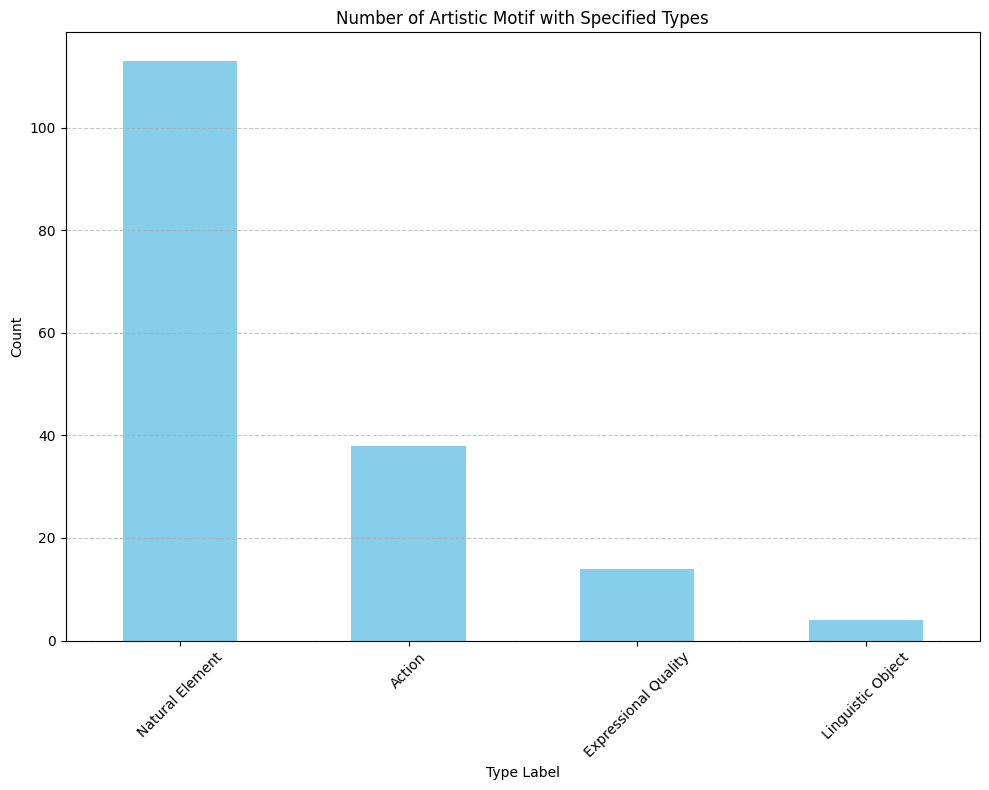

In [48]:
# Count the occurrences of each type_label
type_counts = df['type_label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 8))
type_counts.plot(kind='bar', color='skyblue')

# Add background grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    

plt.xlabel('Type Label')
plt.ylabel('Count')
plt.title('Number of Artistic Motif with Specified Types')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if needed
plt.tight_layout()
plt.show()

Let's now try to ask the more specific question about our time span.
**What are the most frequent subject represented at level 1 in Renaissance period?**

In [43]:
# Define the SPARQL query
query = """		
PREFIX d: <https://w3id.org/icon/data/> 
PREFIX icon: <https://w3id.org/icon/ontology/> 
PREFIX sim: <https://w3id.org/simulation/ontology/>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>

SELECT DISTINCT ?artisticMotif ?level1Label ?artwork ?startDate
WHERE {
    ?production a crm:E12_Production ;
                crm:P108_has_produced ?producedObject ;
                crm:P4_has_time_span ?timeSpan .
    ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
  
    BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
  	FILTER (?startYear >= 1400 && ?startYear <= 1600)
  
    ?producedObject crm:P65_shows_visual_item ?artwork .

    ?preiconRecognition a icon:PreiconographicalRecognition ;
                        icon:aboutWorkOfArt ?artwork .
  
    {
      ?preiconRecognition icon:recognizedArtisticMotif ?artisticMotif .
    }
    UNION
    {
      ?preiconRecognition icon:recognizedComposition ?composition .
      ?composition icon:hasPart ?artisticMotif .
    }
  
    ?artisticMotif icon:hasFactualMeaning | icon:hasExpressionalMeaning | crm:P138_represents ?level1 .
    ?level1 rdfs:label ?level1Label .
}
ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df_level1 = pd.DataFrame(results)
        df_level1 = df_level1.set_axis(['artistic_motif', 'level1_label', 'artwork', 'start_date'], axis='columns')
        print(df_level1.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df_level1  # Uncomment for a better reading of the table
df_level1.info()

Before executing SPARQL query
After executing SPARQL query
                                artistic_motif                   level1_label  \
0       https://w3id.org/icon/data/ART1331-AM1                          woman   
1       https://w3id.org/icon/data/ART1331-AM2                          woman   
2       https://w3id.org/icon/data/ART1331-AM3                     sitting on   
3       https://w3id.org/icon/data/ART1331-AM4                       fountain   
4       https://w3id.org/icon/data/ART1331-AM5                          cross   
5   https://w3id.org/icon/data/ART1004test-AM1                            man   
6  https://w3id.org/icon/data/ART1004test-AM10                          Pluto   
7  https://w3id.org/icon/data/ART1004test-AM11  lending both hands to a woman   
8   https://w3id.org/icon/data/ART1004test-AM5             courteous attitude   
9  https://w3id.org/icon/data/ART1004test-AM13                          woman   

                                  artwork        

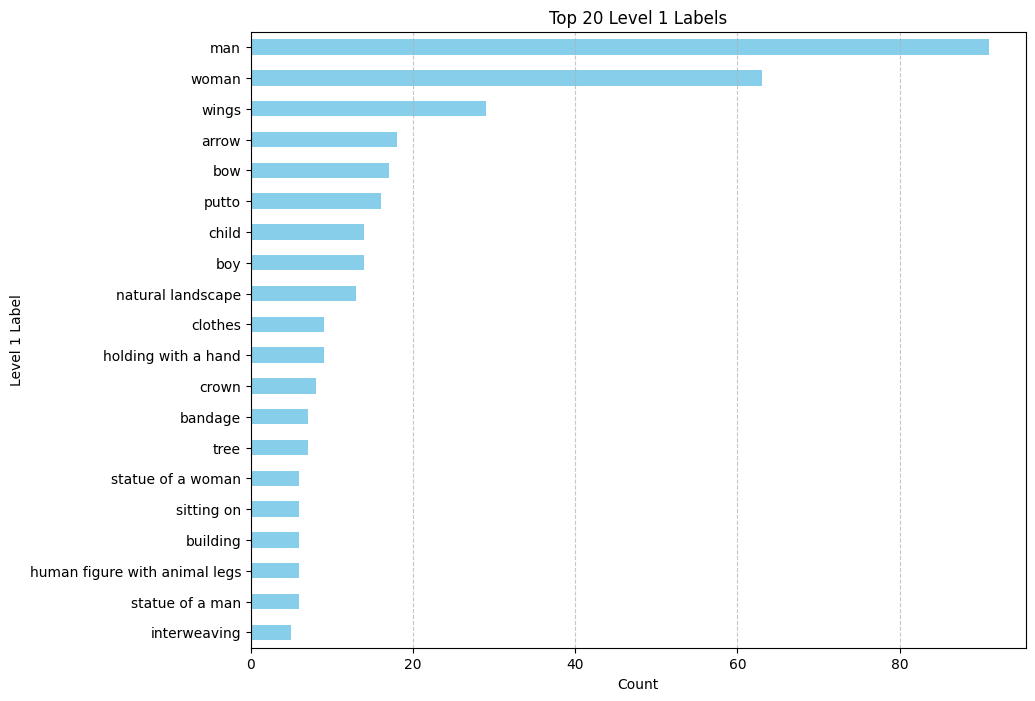

In [49]:
# Check if DataFrame exists and has data
if not df_level1.empty:
    # Get the top 20 value counts of 'level1_label'
    top_level1_labels = df_level1['level1_label'].value_counts().head(20)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    top_level1_labels.sort_values().plot(kind='barh', color='skyblue')

    # Add background grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines on the x-axis
    
    # Customize the plot
    plt.xlabel('Count')
    plt.ylabel('Level 1 Label')
    plt.title('Top 20 Level 1 Labels')
    plt.show()
else:
    print("DataFrame is empty or doesn't exist.")


EXAMPLE OF STRUCTURE

d:ART1000 a icon:Artwork ;
    icon:hasRecogniton d:ART1000-ICONOLREC1,
        d:ART1000-ICREC1,
        d:ART1000-ICREC2,
        d:ART1000-PREICREC1,
        d:ART1000-PREICREC2,
        d:ART1000-PREICREC3,
        d:ART1000-PREICREC4,
        d:ART1000-PREICREC5,
        d:ART1000-PREICREC6 ;
    icon:iconographicallyDepicts d:jupiter,
        d:venus ;
    icon:iconologicallyRepresents d:CF1040 ;
    icon:preiconographicallyDepicts d:dove,
        d:eagle,
        d:man,
        d:woman .

d:ART1000-AM1 a icon:ArtisticMotif ;
    dul:hasQuality <https://w3id.org/icon/data/quality/nudity> ;
    icon:hasFactualMeaning d:woman ;
    icon:isRecognizedArtisticMotifOf d:ART1000-PREICREC1 .

d:ART1000-PREICREC1 a icon:PreiconographicalRecognition ;
    cito:citesForInformation <https://doi.org/10.2307/1522803> ;
    crm:P14_carried_out_by <https://w3id.org/icon/data/person/sofia-baroncini> ;
    icon:aboutWorkOfArt d:ART1000 ;
    icon:preiconographicallyCompliesWith d:ART1000-DESC ;
    icon:recognizedArtisticMotif d:ART1000-AM1 

d:woman a icon:NaturalElement ;
    rdfs:label "woman" ;
    owl:sameAs <https://iconclass.org/31A72> ;
    icon:isFactualMeaningOf d:ART1000-AM1,
        d:ART1001test-AM1,
        d:ART1002test-AM1,
        d:ART1004test-AM13, ecc.

d:OBJ1000 a crm:E25_Human_Made_Feature ;
    rdfs:label "Raphael, Venus imploring Jupiter, 1518, Rome, Villa Farnesina" ;
    crm:P102_has_title <https://w3id.org/icon/data/title/venus-imploring-jupiter> ;
    crm:P2_has_type <http://vocab.getty.edu/aat/300177433> ;
    crm:P53_has_former_or_current_location <https://w3id.org/icon/data/place/rome-villa-farnesina> ;
    crm:P56i_is_found_on d:OBJ1151ext-vault ;
    crm:P65_shows_visual_item d:ART1000 ;
    crm:P67_refers_to <https://doi.org/10.2307/1522803> ;
    foaf1:depiction <https://commons.wikimedia.org/wiki/File:Raffael,_Loggia_di_Psiche,_Villa_Farnesina,_Rome_11.jpg> .

In [5]:
# Define the SPARQL query
query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX d: <https://w3id.org/icon/data/>

SELECT DISTINCT ?producedObject ?objectTitle ?period ?author ?motivator ?startDate 
WHERE {
  ?production a crm:E12_Production ;
              crm:P108_has_produced ?producedObject ;
              crm:P4_has_time_span ?timeSpan .
  ?timeSpan crm:P82a_begin_of_the_begin ?startDate .
  BIND (xsd:integer(SUBSTR(?startDate, 1, 4)) AS ?startYear) .
  ?producedObject crm:P102_has_title ?objectTitle .
  
  OPTIONAL { ?production crm:P10_falls_within ?period }
  OPTIONAL { ?production crm:P14_carried_out_by ?author }
  OPTIONAL { ?production crm:P17_was_motivated_by ?motivator }

  # Filter for start year after 1400
  FILTER (?startYear >= 1400 && ?startYear <= 1600)
}
ORDER BY ?startDate
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df1 = pd.DataFrame(results)
        df1 = df1.set_axis(['produced_object', 'object_title', 'period', 'author', 'motivator', 'start_date'], axis='columns')
        print(df1.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df1  # Uncomment for a better reading of the table
df1.info()

Before executing SPARQL query
After executing SPARQL query
                          produced_object  \
0      https://w3id.org/icon/data/OBJ1117   
1      https://w3id.org/icon/data/OBJ1118   
2      https://w3id.org/icon/data/OBJ1173   
3   https://w3id.org/icon/data/OBJ1191ext   
4   https://w3id.org/icon/data/OBJ1202ext   
5      https://w3id.org/icon/data/OBJ1331   
6  https://w3id.org/icon/data/OBJ1004test   
7      https://w3id.org/icon/data/OBJ1007   
8  https://w3id.org/icon/data/OBJ1008test   
9      https://w3id.org/icon/data/OBJ1015   

                                 period author motivator           start_date  \
0                                  None   None      None  1400-01-01T00:00:00   
1                                  None   None      None  1400-01-01T00:00:00   
2                                  None   None      None  1400-01-01T00:00:00   
3                                  None   None      None  1400-01-01T00:00:00   
4                                  None 

In [22]:
# Define the SPARQL query
query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX d: <https://w3id.org/icon/data/>

SELECT ?period ?periodLabel
WHERE {
  ?period a crm:E4_Period .
  OPTIONAL { ?period rdfs:label ?periodLabel }
}
"""

try:
    # Execute the query and retrieve the results
    print("Before executing SPARQL query")
    results = iconology_graph.query(query)
    print("After executing SPARQL query")
    
    print(results)
    
    # Check if results exist
    if results:
        df2 = pd.DataFrame(results)
        df2 = df2.set_axis(['period', 'period_label'], axis='columns')
        print(df2.head(10))  # Show the first 10 rows of the DataFrame
    else:
        print("No results returned from the SPARQL query")
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df2  # Uncomment for a better reading of the table

Before executing SPARQL query
After executing SPARQL query
                                              period  \
0               http://vocab.getty.edu/aat/300022045   
1  https://w3id.org/icon/data/period/florentine-m...   
2  https://w3id.org/icon/data/period/venetian-hig...   
3               http://vocab.getty.edu/aat/300021144   
4  https://w3id.org/icon/data/period/florentine-r...   
5  https://w3id.org/icon/data/period/manfredian-o...   
6               http://vocab.getty.edu/aat/300020072   
7               http://vocab.getty.edu/aat/300020072   
8               http://vocab.getty.edu/aat/300020666   
9               http://vocab.getty.edu/aat/300020666   

                                period_label  
0                        Counter-Reformation  
1                       Florentine Mannerism  
2                  Venetian High Renaissance  
3                                  Mannerism  
4                     Florentine Renaissance  
5            Manfredian or Federician peri

,period,period_label
0,http://vocab.getty.edu/aat/300022045,Counter-Reformation
1,https://w3id.org/icon/data/period/florentine-m...,Florentine Mannerism
2,https://w3id.org/icon/data/period/venetian-hig...,Venetian High Renaissance
3,http://vocab.getty.edu/aat/300021144,Mannerism
4,https://w3id.org/icon/data/period/florentine-r...,Florentine Renaissance
5,https://w3id.org/icon/data/period/manfredian-o...,Manfredian or Federician period
6,http://vocab.getty.edu/aat/300020072,Ancient Greece
7,http://vocab.getty.edu/aat/300020072,Ancient Greek
8,http://vocab.getty.edu/aat/300020666,Late Antique Roman Style (IV - V Century)
9,http://vocab.getty.edu/aat/300020666,Late Roman Antiquity


In [25]:
# Merge both DataFrames on the 'period' column
merged_df = pd.merge(df1, df2, on='period', how='left')

df1.info()


# Explode the lists in the 'period_label' column into separate rows
exploded_df = df1.explode('period_label')

# Get unique values from the exploded 'period_label' column
unique_values = exploded_df['period_label'].dropna().unique()
print(unique_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   produced_object  168 non-null    object
 1   period           9 non-null      object
 2   author           93 non-null     object
 3   motivator        9 non-null      object
 4   start_date       168 non-null    object
 5   object_title     168 non-null    object
 6   period_label     9 non-null      object
dtypes: object(7)
memory usage: 9.3+ KB
[rdflib.term.Literal('Renaissance') rdflib.term.Literal('Medieval')
 rdflib.term.Literal('Middle Ages')
 rdflib.term.Literal('Florentine Renaissance')
 rdflib.term.Literal('Venetian High Renaissance')
 rdflib.term.Literal('Florentine Mannerism')
 rdflib.term.Literal('Mannerism')]
